In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [2]:
Data = pd.read_excel("Infiltration_example.xlsx")
Data.head(10)

,date,treatment,plot,pressure,suction,time,volume
0,2021-03-27,2,1,1,-1 cm,0,49.1
1,2021-03-27,2,1,1,-1 cm,300,45.8
2,2021-03-27,2,1,1,-1 cm,600,42.4
3,2021-03-27,2,1,1,-1 cm,900,38.9
4,2021-03-27,2,1,1,-1 cm,1200,34.8
5,2021-03-27,2,1,1,-1 cm,1500,31.3
6,2021-03-27,2,1,5,-5 cm,0,29.1
7,2021-03-27,2,1,5,-5 cm,300,28.6
8,2021-03-27,2,1,5,-5 cm,600,27.2
9,2021-03-27,2,1,5,-5 cm,900,26.0


# Note
Convert to date format to datetime and check the data types

In [3]:
Data.dtypes

date         datetime64[ns]
treatment             int64
plot                  int64
pressure              int64
suction              object
time                  int64
volume              float64
dtype: object

In [4]:
dates = [datetime(2021,3,27), datetime(2021,5,3)]

# Note
Remove rows where 'time' is 0, 300, 600, or 900

In [5]:
Data = Data[(Data['time'] != 0) & (Data['time'] != 300) & (Data['time'] != 600) & (Data['time'] != 900)]
Data

,date,treatment,plot,pressure,suction,time,volume
4,2021-03-27,2,1,1,-1 cm,1200,34.8
5,2021-03-27,2,1,1,-1 cm,1500,31.3
10,2021-03-27,2,1,5,-5 cm,1200,24.6
11,2021-03-27,2,1,5,-5 cm,1500,23.3
16,2021-03-27,2,1,7,-7 cm,1200,13.4
...,...,...,...,...,...,...,...
563,2021-05-03,8,4,1,-1 cm,1500,2.0
568,2021-05-03,8,4,5,-5 cm,1200,21.0
569,2021-05-03,8,4,5,-5 cm,1500,5.0
574,2021-05-03,8,4,7,-7 cm,1200,24.5


# Note
Calculate water flux J_w

In [6]:
# Filtering out pressures 1, 5, and 7
filtered_data = Data[Data['pressure'].isin([1, 5, 7])]

# Pivoting the data to get volumes at different times side by side for the same pressure
pivot_table = filtered_data.pivot_table(index=['date', 'treatment', 'plot', 'pressure'], 
                                        columns='time', 
                                        values='volume',
                                        aggfunc='mean').reset_index()

# Calculating the volume difference between 1200s and 1500s
pivot_table['volume_diff'] = (pivot_table[1200] - pivot_table[1500]) ###set it as stable


In [7]:
# Area calculation in cm^2
radius = 2.25  # radius in cm
area_cm2 = np.pi * (radius ** 2)  # area in cm^2

# Calculating J_w in cm/s, considering volume as cm^3 (mL) over the area in cm^2
pivot_table['J_w'] = pivot_table['volume_diff'] / 300 / area_cm2  # the unit of J_w transferred to cm/s

pivot_table['pressure'] = -pivot_table['pressure']

# Display the updated table with calculated J_w values
print(pivot_table[['date', 'treatment', 'plot', 'pressure', 'J_w']])

time       date  treatment  plot  pressure       J_w
0    2021-03-27          2     1        -1  0.000734
1    2021-03-27          2     1        -5  0.000272
2    2021-03-27          2     1        -7  0.000189
3    2021-03-27          2     2        -1  0.001195
4    2021-03-27          2     2        -5  0.000482
..          ...        ...   ...       ...       ...
91   2021-05-03          8     3        -5  0.003877
92   2021-05-03          8     3        -7  0.003039
93   2021-05-03          8     4        -1  0.005449
94   2021-05-03          8     4        -5  0.003353
95   2021-05-03          8     4        -7  0.002620

[96 rows x 5 columns]


# Note
Calculate Ks and lambda_c

In [8]:
def infiltration_model(h, Ks, lambda_c, r):
    pi = np.pi
    return Ks * np.exp(h / lambda_c) * (1 + (4 * lambda_c) / (pi * r))

# Example radius in cm converted to meters
r = 2.25 # radius in meters

# Container to hold the results
results = []

# Loop through each unique combination of date, treatment, and plot
for (date, treatment, plot), group in pivot_table.groupby(['date', 'treatment', 'plot']):
    # Extract h_values and Jw_values
    h_values = group['pressure'].values 
    Jw_values = group['J_w'].values
    
    # Initial guesses for Ks and lambda_c
    initial_guesses = [1e-4, 1e2]   # Adjust based on your data and expectations

    # Perform curve fitting
    try:
        params, cov = curve_fit(lambda h, Ks, lambda_c: infiltration_model(h, Ks, lambda_c, r),
                                h_values, Jw_values, p0=initial_guesses,
                                maxfev=10000,
                                bounds=((1e-7, 1), (1e-2, 1e4)))  # Non-negative bounds
        results.append({
            'date': date, 
            'treatment': treatment, 
            'plot': plot, 
            'Ks': params[0], 
            'lambda_c': params[1]
        })
    except RuntimeError as e:
        print(f"Failed to fit data for plot {plot} on {date} with treatment {treatment}: {e}")
        

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

         date  treatment  plot        Ks   lambda_c
0  2021-03-27          2     1  0.000274   4.219237
1  2021-03-27          2     2  0.000457   4.136911
2  2021-03-27          2     3  0.000250   4.995344
3  2021-03-27          2     4  0.000411   2.371360
4  2021-03-27          4     1  0.000412   3.589239
5  2021-03-27          4     2  0.000524   4.042443
6  2021-03-27          4     3  0.000343   4.638018
7  2021-03-27          4     4  0.000197   6.693450
8  2021-03-27          6     1  0.000182   8.864767
9  2021-03-27          6     2  0.000386   6.254573
10 2021-03-27          6     3  0.000435   6.450501
11 2021-03-27          6     4  0.000402   7.574699
12 2021-03-27          8     1  0.000444   6.285604
13 2021-03-27          8     2  0.000289  10.392625
14 2021-03-27          8     3  0.000520   9.466700
15 2021-03-27          8     4  0.000320   7.011327
16 2021-05-03          2     1  0.000629  10.586142
17 2021-05-03          2     2  0.000564  11.158372
18 2021-05-0

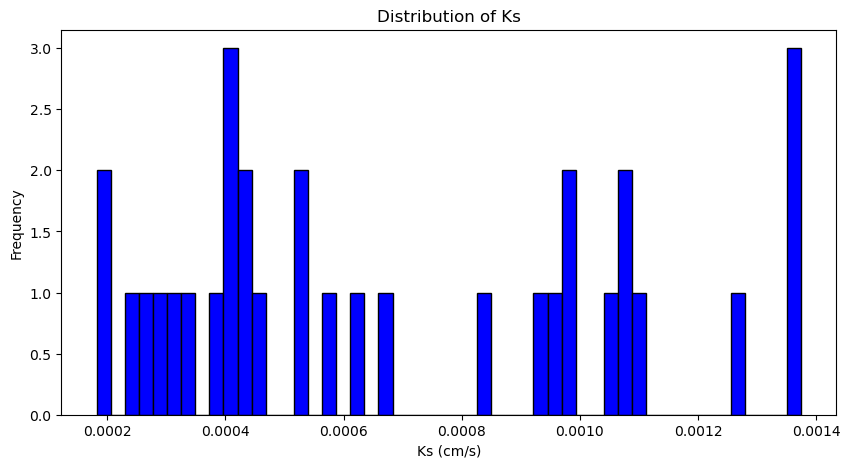

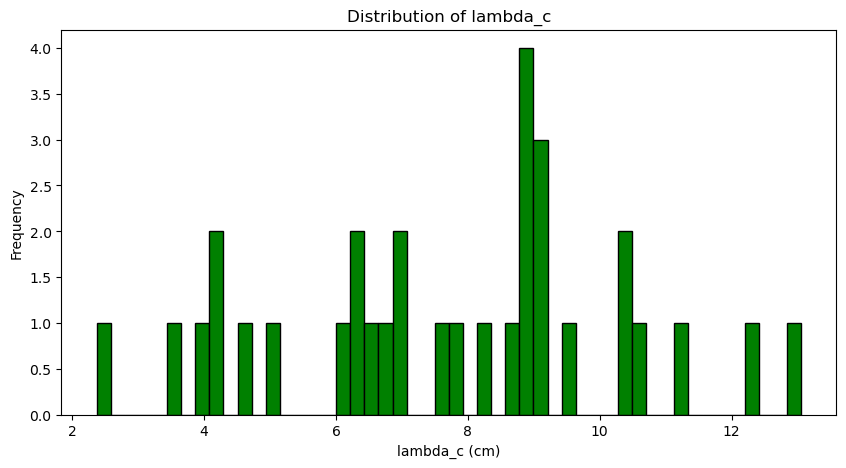

In [9]:
import matplotlib.pyplot as plt

# plot the distribution of Ks
plt.figure(figsize=(10, 5))
plt.hist(results_df['Ks'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Ks')
plt.xlabel('Ks (cm/s)')
plt.ylabel('Frequency')
plt.show()

# plot the distribution of lambda_c
plt.figure(figsize=(10, 5))
plt.hist(results_df['lambda_c'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of lambda_c')
plt.xlabel('lambda_c (cm)')
plt.ylabel('Frequency')
plt.show()


# Note
Merge parameters Ks and lamda_c to oringinal dataframe

In [10]:
merged_df = pd.merge(pivot_table, results_df, on=['date', 'treatment', 'plot'])
print(merged_df)

         date  treatment  plot  pressure  1200  1500  volume_diff       J_w  \
0  2021-03-27          2     1        -1  34.8  31.3          3.5  0.000734   
1  2021-03-27          2     1        -5  24.6  23.3          1.3  0.000272   
2  2021-03-27          2     1        -7  13.4  12.5          0.9  0.000189   
3  2021-03-27          2     2        -1  39.5  33.8          5.7  0.001195   
4  2021-03-27          2     2        -5  24.0  21.7          2.3  0.000482   
..        ...        ...   ...       ...   ...   ...          ...       ...   
91 2021-05-03          8     3        -5  25.5   7.0         18.5  0.003877   
92 2021-05-03          8     3        -7  24.0   9.5         14.5  0.003039   
93 2021-05-03          8     4        -1  28.0   2.0         26.0  0.005449   
94 2021-05-03          8     4        -5  21.0   5.0         16.0  0.003353   
95 2021-05-03          8     4        -7  24.5  12.0         12.5  0.002620   

          Ks  lambda_c  
0   0.000274  4.219237  
1


# Note
Calculate Kh

In [11]:
merged_df['Kh'] = merged_df['Ks'] * np.exp(merged_df['pressure'] / merged_df['lambda_c'])
merged_df['Kh_final'] = merged_df['Kh'] * 10000 ### transfer unit to 10^-4 cm/s
merged_df

,date,treatment,plot,pressure,1200,1500,volume_diff,J_w,Ks,lambda_c,Kh,Kh_final
0,2021-03-27,2,1,-1,34.8,31.3,3.5,0.000734,0.000274,4.219237,0.000216,2.161190
1,2021-03-27,2,1,-5,24.6,23.3,1.3,0.000272,0.000274,4.219237,0.000084,0.837462
2,2021-03-27,2,1,-7,13.4,12.5,0.9,0.000189,0.000274,4.219237,0.000052,0.521316
3,2021-03-27,2,2,-1,39.5,33.8,5.7,0.001195,0.000457,4.136911,0.000359,3.586001
4,2021-03-27,2,2,-5,24.0,21.7,2.3,0.000482,0.000457,4.136911,0.000136,1.363606
...,...,...,...,...,...,...,...,...,...,...,...,...
91,2021-05-03,8,3,-5,25.5,7.0,18.5,0.003877,0.001355,7.851162,0.000717,7.165103
92,2021-05-03,8,3,-7,24.0,9.5,14.5,0.003039,0.001355,7.851162,0.000555,5.553804
93,2021-05-03,8,4,-1,28.0,2.0,26.0,0.005449,0.001089,8.218797,0.000964,9.642435
94,2021-05-03,8,4,-5,21.0,5.0,16.0,0.003353,0.001089,8.218797,0.000593,5.926800


In [12]:
merged_df.to_excel('Kh.xlsx', index=False)